## Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Learning Objective

At the end of the experiment, you will be able to :

1. Understand the role of hyperparameter learning rate
2. Observe what happens to the performance of the model when we set learning rate values to high or low

## Experiment walkthrough video

Please refer video explanation of U4W21_50_Weight_InitializationandUpdates for this. This experiment is an extension of the same.

## Dataset

### Description

The dataset used for this experiment is CIFAR-100. It  has 100 classes which contains 600 images for each class. There are 500 training images and 100 testing images per class. These 100 classes are grouped into 20 superclasses. Each image comes with the class and superclass it belongs to.

Here is the list of classes in the CIFAR-100:

| Superclass 	 | Classes|
|--------------------|-------------|
|aquatic mammals | 	beaver, dolphin, otter, seal, whale |
|fish |	aquarium fish, flatfish, ray, shark, trout |
|flowers| 	orchids, poppies, roses, sunflowers, tulips |
|food containers| 	bottles, bowls, cans, cups, plates|
|fruit and vegetables| 	apples, mushrooms, oranges, pears, sweet peppers|
|household electrical devices | clock, computer keyboard, lamp, telephone, television|
|household furniture| 	bed, chair, couch, table, wardrobe|
|insects | 	bee, beetle, butterfly, caterpillar, cockroach |
|large carnivores| 	bear, leopard, lion, tiger, wolf|
|large man-made outdoor things |	bridge, castle, house, road, skyscraper|
|large natural outdoor scenes |	cloud, forest, mountain, plain, sea|
|large omnivores and herbivores |	camel, cattle, chimpanzee, elephant, kangaroo|
|medium-sized mammals |	fox, porcupine, possum, raccoon, skunk|
|non-insect invertebrates|	crab, lobster, snail, spider, worm|
|people| 	baby, boy, girl, man, woman|
|reptiles |	crocodile, dinosaur, lizard, snake, turtle|
|small mammals| 	hamster, mouse, rabbit, shrew, squirrel |
|trees|	maple, oak, palm, pine, willow |
|vehicles 1 |	bicycle, bus, motorcycle, pickup truck, train |
|vehicles 2 |	lawn-mower, rocket, streetcar, tank, tractor |



The dataset is downloaded from following url :

https://www.cs.toronto.edu/~kriz/cifar.html

## AI / ML Technique

### Learning Rate



This is the most important hyper parameter to train the neural network. A good learning rate can make a huge difference in between a model that didn't learn anything and a model that learned everything from the data. 

Let us see some intersting facts about the learning rates :

1. While training the model when we observe that the loss is exploding we infer that the value chosen for learning rate is high.
2. If you choose learning rate value as too high then there is a chance to overshoot the local minima or good result and in next iteration there is a chance to undershoot the good result.
3.  If you choose learning rate value as too low then there is a slow convergence. This can even degrade the performance of the model.

In this experiment you will be able to understand how the performance of the model varies when we change the learning rate value.

In [ ]:
! wget https://cdn.talentsprint.com/aiml/Experiment_related_data/week9/Exp6/config.py")
! wget https://cdn.talentsprint.com/aiml/Experiment_related_data/week9/Exp6/utils.py")
    

### Importing required Packages

In [ ]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# Importing config.py file
import config as cf
from utils import *

# Importing python packages
import os
import math
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Checking for GPU instance
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Intilizaing the accuracy value as zero
best_acc = 0

### Preparing the Dataset

In [ ]:
print('\n[Phase 1] : Data Preparation')

# Dataset
dataset = 'cifar100'

# Preparing the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
]) # mean and std transformation

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
])


[Phase 1] : Data Preparation


### Downloading and Loading the dataset

The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.


In [ ]:
# Number of classes in the dataset
num_classes = 100

In [ ]:
# Downloading the dataset
trainset = torchvision.datasets.CIFAR100(root='data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='data', train=False, download=False, transform=transform_test)

# Loading the dataset 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data


### Let us define the network

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes, init_mode='xavier'):  # Supports 'zero', 'normal', 'xavier', 'he' initialization
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
        
        if init_mode == 'zero':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.zero_()   # Fill tensor elements with zeros
                    if m.bias is not None:
                        m.bias.data.zero_()
        
        if init_mode == 'normal':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.normal_()   # Fill tensor elements with random numbers from normal distribution
                    if m.bias is not None:
                        m.bias.data.normal_()
        
        if init_mode == 'xavier':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                    n = fan_in + fan_out
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # Number of rows
                    fan_in = size[1] # Number of columns
                    variance = math.sqrt(2.0/(fan_in+fan_out))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
        
        if init_mode == 'he':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # Number of rows
                    fan_in = size[1] # Number of columns
                    variance = math.sqrt(2.0/(fan_in))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
                
                
    # Forward Pass
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return(out)

### Training with Xavier init

In [ ]:
# Calling the model with Xavier
net = LeNet(num_classes, init_mode='xavier')

# Checking for GPU instance 
net = net.to(device)

### Defining the Loss Function

In [ ]:
# Intiliazing the loss
criterion = nn.CrossEntropyLoss()

### Training the Model

In [ ]:
def train(epoch):
    print('\nEpoch: %d' % epoch)

    net.train()
    train_loss = 0
    correct = 0
    total = 0

    # Looping over train data
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        # Converting targets and inputs into pytorch variables
        inputs, targets = inputs.to(device), targets.to(device)

        # Set the parameters of gradients to zero
        optimizer.zero_grad()

        # Forward Pass
        outputs = net(inputs)

        # Storing the outputs size
        size_ = outputs.size()

        # Reducing the dimenssion
        outputs_ = outputs.view(size_[0], num_classes)

        # Calculating the loss
        loss = criterion(outputs_, targets)

        # Backward Pass
        loss.backward()

        # Optimizer Step
        optimizer.step()

        # Calculating the tarining loss
        train_loss += loss.item()

        # Predicting the values
        _, predicted = torch.max(outputs_.data, 1)

        # Storing the targets size
        total += targets.size(0)

        # Calculating the corrected values
        correct += predicted.eq(targets.data).cpu().sum().item()

        # Printing the data
        if batch_idx%30 == 0 or batch_idx == len(trainloader)-1:
            # Printing the progress bar
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Storing number of epoch,loss and accuracy in a file    
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))

### Testing the Model

In [ ]:
def test(epoch):
    global best_acc

    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    # Looping over test data
    for batch_idx, (inputs, targets) in enumerate(testloader):

        # Converting inputs and targets into pytorch variables
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward Pass
        outputs = net(inputs)

        # Storing the outputs size
        size_ = outputs.size()

        # Reducing the dimenssions
        outputs_ = outputs.view(size_[0], num_classes)

        # Calculating the loss
        loss = criterion(outputs_, targets)

        # Calculating the test loss
        test_loss += loss.item()

        # Storing the predicted values
        _, predicted = torch.max(outputs_.data, 1)

        # Storing the targets size
        total += targets.size(0)

        # Caluculating the correct values
        correct += predicted.eq(targets.data).cpu().sum().item()
        
        # Printing the data
        if batch_idx%30 == 0 or batch_idx == len(testloader)-1:
            # Printing the progress bar
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Printing the validation loss
    print('val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total)
    # Storing number of epoch,loss and accuracy in a file
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    # Checking for best accuracy
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net,
            'acc': acc,
            'epoch': epoch,
        }
        # Checking whether its a directory or not
        if not os.path.isdir('../checkpoint'):
            # Creating a directory
            os.mkdir('../checkpoint')
        # Saving the data
        torch.save(state, '../checkpoint_ckpt.t7')
        # Storing the best accuracy
        best_acc = acc

In [ ]:
experiment = 'lr_schedule'

# Creating files in write mode
train_loss_file = open(experiment+"train_loss.txt", "w")
val_loss_file = open(experiment+"val_loss.txt", "w")

In [ ]:
# This code cell takes 20 mins to run

# Training and testing the model for 60 epochs
for epoch in range(0, 60):
    if epoch == 50:
        optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
    if epoch == 30:
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    if epoch == 0:
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    # Training the model
    train(epoch)
    # Testing the model
    test(epoch)
    
# Closing the files 
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 4.359 | Acc: 3.704% (1852/50000)  391/391 
 [==================================>] | Loss: 4.032 | Acc: 8.790% (879/10000)   100/100 
val_loss:  4.031729457378387 accuracy:  8.79
Saving..

Epoch: 1
 [==================================>] | Loss: 3.794 | Acc: 11.654% (5827/50000) 391/391 
 [==================================>] | Loss: 3.648 | Acc: 14.040% (1404/10000) 100/100 
val_loss:  3.648398187160492 accuracy:  14.04
Saving..

Epoch: 2
 [==================================>] | Loss: 3.500 | Acc: 16.642% (8321/50000) 391/391 
 [==================================>] | Loss: 3.418 | Acc: 18.470% (1847/10000)

### Plotting the training curves

60 60


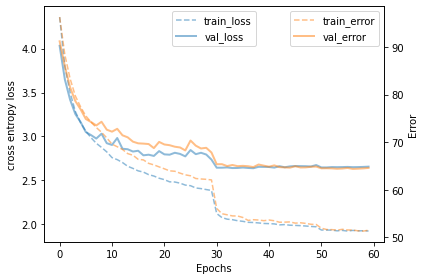

In [ ]:
training_curves(experiment)